In [5]:
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import pandas as pd
from scipy.special import softmax

from timeit import default_timer as timer
import random
import cv2

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as tkr

from tf_keras_vis.utils.callbacks import Print
# tf.compat.v1.disable_eager_execution()

from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize
#import vis.visualization
from tf_keras_vis.activation_maximization import ActivationMaximization

from tensorflow.python.framework import ops

import json
import pickle
import os
import sys
sys.path.append("../python/")
from helpers import *
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

In [6]:
# Globals
NUM_CHANNELS = 1
RESOLUTION_LIST = [128] # 64, 128] #, 224, 384]
SCENARIO_LIST = ["PrPo_Im"] #, "Pr_Im", "Pr_PoIm", "Pr_Po_Im"]
NUM_EPOCHS = 20
SAVED_MODEL_DIR = '../../results/models/'
MODEL_PERFORMANCE_METRICS_DIR = '../../results/model-performance/'
FULL_MODEL_PATH = '../../results/models/opt-cnn-PrPo_Im-128-px/model'

In [31]:
## these can also be globally set.
trial_seed = 1
image_sets = createResolutionScenarioImageDict(RESOLUTION_LIST, SCENARIO_LIST)
training_images, validation_images, training_labels, validation_labels =  train_test_split(np.array([np.expand_dims(x[0],axis=2) for x in image_sets[128]["PrPo_Im"]]), 
                np.array([x[1] for x in image_sets[128]["PrPo_Im"]]), stratify= np.array([x[1] for x in image_sets[128]["PrPo_Im"]]), test_size=.2, random_state = trial_seed)
        

In [8]:
m = models.load_model(FULL_MODEL_PATH)

In [32]:
def guided_backprop(index, model, activation_layer):#101
    # Reference: https://colab.research.google.com/drive/17tAC7xx2IJxjK700bdaLatTVeDA02GJn#scrollTo=jgTRCYgX4oz-&line=1&uniqifier=1
    backprop_image = validation_images[index]    
    @tf.custom_gradient
    def guidedRelu(x):
        def grad(dy):
            return tf.cast(dy > 0, "float32") * tf.cast(x > 0, "float32") * dy
        return tf.nn.relu(x), grad

    modified_model = models.Model(
        inputs = [model.inputs],
        outputs = [model.get_layer(activation_layer).output]
    )
    layer_dict = [layer for layer in modified_model.layers[1:] if hasattr(layer,'activation')]
    for layer in layer_dict:
        if layer.activation == tf.keras.activations.relu:
            layer.activation = guidedRelu

    with tf.GradientTape() as tape:
        inputs = tf.cast(backprop_image, tf.float32)
        tape.watch(inputs)
        outputs = modified_model(inputs)

    grads = tape.gradient(outputs,inputs)[0]
    return grads #saliency[0]

In [33]:
gbp101 = guided_backprop([101], m, 'conv2d_4' )

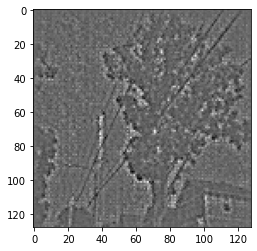

In [34]:
plt.imshow(gbp101, cmap="gist_gray")

The deprocessing function standardizes (subtract mean, divide by standard dev) the image. This makes for a higher contrast image, but not too informative in our case, given the low resolution.

In [35]:
# Reference: https://colab.research.google.com/drive/17tAC7xx2IJxjK700bdaLatTVeDA02GJn#scrollTo=4-OduFD-wH14&line=15&uniqifier=1
def deprocess_image(x):
    """Same normalization as in:
    https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py
    """
    # normalize tensor: center on 0., ensure std is 0.25
    x = x.copy()
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.25

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

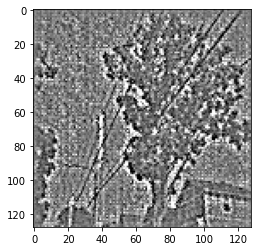

In [27]:
plt.imshow(np.flip(deprocess_image(np.array(gbp101)),-1), cmap = "gist_gray")